In [279]:
!pip install Unidecode
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import unidecode

In [280]:
#liste des gares API SNCF
url_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC"
gares = requests.get(url_gares)
wb_gares = gares.json()

df_gares = pd.DataFrame(wb_gares)
df_gares.head(2)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [281]:
#frequentation des gares API SNCF
url_freq_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC"
freq_gares = requests.get(url_freq_gares)
wb_freq_gares = freq_gares.json()

df_freq_gares = pd.DataFrame(wb_freq_gares)
df_freq_gares.head(2)

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Agay,87757559,83530,c,25094,25094,15390,15390,22284,22284,15093,15093,14154,14154,19240,19240,19121,19121


In [282]:
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [283]:
#nous avons plus de données sur les gares que sur la frequentation
print(len(df_gares))
print(len(df_freq_gares))

3819
2970


In [284]:
#on regarde quelles gares de la liste des gares ne sont pas dans la database qui contient les frequentations
outer_merged = pd.merge(df_gares, df_freq_gares, how="outer", on=["code_uic"])
outer_merged[outer_merged['nom_gare'].isna()==True][['code_uic', 'libelle']]
#ce sont de petites gares donc on va considérer seulement celles de la database des frequentations

,code_uic,libelle
3,87784488,Cases-de-Pène
12,87396671,La Chartre-sur-le-Loir
35,87271320,La Courneuve-Dugny
39,87172411,Margut-Fromy
49,87172593,Vouziers
...,...,...
3785,87286807,Genech
3793,87755835,La Motte-Ste-Rosseline
3799,87729210,Port-Fluvial-de-Chalon-sur-Saône
3801,87286252,Rougebarre


In [285]:
#on fusionne donc les dataframes à partir de df_freq_gares
left_merged = pd.merge(df_freq_gares, df_gares, how="left", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'nom_gare', 'x_wgs84','y_wgs84']]
df_gares_merged.head()

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84
0,87481614,22773,Abbaretz,-1.524313,47.555462
1,87757559,15390,Agay,6.856677,43.431734
2,87734129,50677,Aigueperse,3.198198,46.014744
3,87775858,5683,Aigues-Mortes,4.191092,43.570880
4,87741769,89504,Aime - La Plagne,6.648695,45.554397


(array([3.271e+03, 1.100e+01, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00]),
 array([1.00000000e+00, 1.52624522e+07, 3.05249034e+07, 4.57873546e+07,
        6.10498058e+07, 7.63122570e+07, 9.15747082e+07, 1.06837159e+08,
        1.22099611e+08, 1.37362062e+08, 1.52624513e+08]),
 <BarContainer object of 10 artists>)

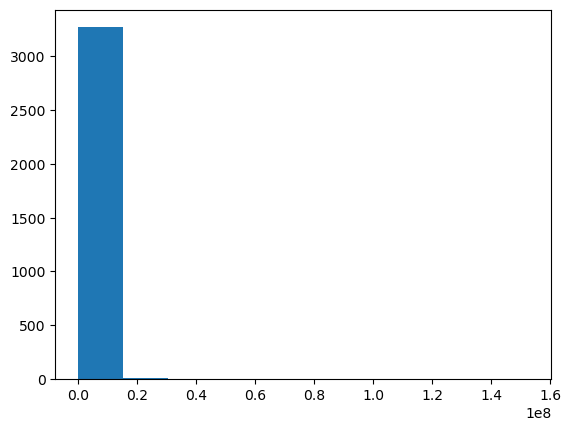

In [286]:
#gérer les cas 0 et NaN --> pour 0, on les enlève (gares désafectées) mais il faudra gérer le cas NaN 

df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])

(array([ 16.,  32.,  92., 259., 639., 944., 774., 403., 121.,  11.]),
 array([ 0.        ,  1.88434913,  3.76869826,  5.65304739,  7.53739652,
         9.42174565, 11.30609478, 13.19044391, 15.07479304, 16.95914217,
        18.8434913 ]),
 <BarContainer object of 10 artists>)

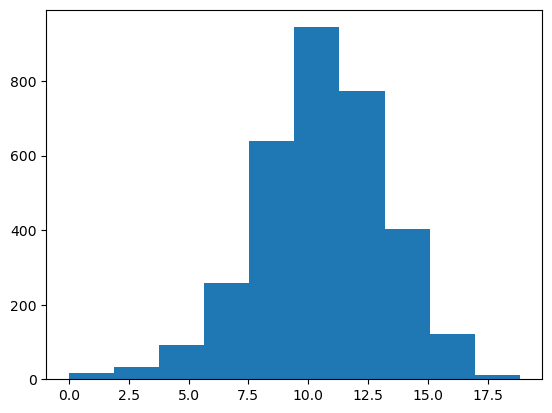

In [287]:
#pour mieux visualiser les frequentations, on passe au log
df_gares_merged['log_total_voyageurs_non_voyageurs_2020'] = np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.hist(df_gares_merged['log_total_voyageurs_non_voyageurs_2020'])


In [288]:
#filtre sur les frequentations : on ne garde que les gares les plus frequentees
df_gares_principales = df_gares_merged[df_gares_merged['log_total_voyageurs_non_voyageurs_2020']>= 14]

#on regarde ensuite les gares tres frequentees pour lesquelles il nous manque les coordonnees gps
df_gares_manquantes  = df_gares_principales[df_gares_principales['x_wgs84'].isna()==True]
df_gares_manquantes.head()


,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
382,87758607,7980634,Châtelet les Halles,NaN,NaN,15.892528
637,87756403,4085871,Monaco-Monte-Carlo,NaN,NaN,15.223045
975,87113209,3862190,Pantin,NaN,NaN,15.166745
979,87758904,107666015,Paris Gare du Nord,NaN,NaN,18.494545
1069,87654798,2865667,Rosa Parks,NaN,NaN,14.868312


In [289]:
#on sort les donnees manquantes du dataframe, on va maintenant les chercher grace a d'autres sources de donnees
df_gares_principales = df_gares_principales.dropna()

In [290]:
#on recupere les donnees manquantes (sauf monaco, mais pas vrmt en France) grace à l'API de la region idf
url_region_idf = "https://data.iledefrance.fr/api/v2/catalog/datasets/gares-et-points-darrets-du-reseau-transilien/exports/json?limit=-1&offset=0&timezone=UTC"

region_idf = requests.get(url_region_idf)
wb_region_idf = region_idf.json()

df_region_idf_initial = pd.DataFrame(wb_region_idf)

#on se restreint aux gares dont les donnees geo sont manquantes dans le dataframe des gares principales
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]
df_region_idf


,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
62,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0
166,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0
207,87113696,871136,ROSNY BOIS PERRIER,ROSNY BOIS PERRIER,GARE DE ROSNY BOIS PERRIER,Rosny B. P.,Rosny-sous-Bois Perrier,Rue Léon Blum 93110 Rosny sous bois,93064,[Rosny-sous-Bois],610640.0,2431610.0,"{'lon': 2.48149612336, 'lat': 48.8827036731}",3.0,0.0
228,87654798,876547,Rosa Parks,Rosa Parks,GARE DE ROSA PARKS,None,Rosa Parks,Rue Gaston Tessier,75119,[Paris],602710.0,2433136.0,"{'lon': 2.37345, 'lat': 48.8965}",1.0,0.0
241,87113522,871135,LE CHENAY GAGNY,LE CHENAY GAGNY,GARE DE CHENAY GAGNY,Chenay-Gagny,Gagny le Chênay,5 rue du chemin de fer 93220 Gagny,93032,[Gagny],615860.0,2431016.0,"{'lon': 2.5526064160699997, 'lat': 48.8772579359}",4.0,0.0
326,87113795,871137,VILLIERS SUR MARNE PLESSIS TREVISE,VILLIERS SUR MARNE PLESSIS TREVISE,GARE DE VILLIERS SUR MARNE PLESSIS TREVISE,Villiers,Villiers-sur-Marne - Le Plessis-Trévise,place Pierre Sémard 94350 VILLIERS-SUR-MARNE,94079,[Villiers-sur-Marne],615121.0,2424997.0,"{'lon': 2.54232320839, 'lat': 48.8231802547}",4.0,0.0
327,87113779,871137,LES BOULLEREAUX CHAMPIGNY,LES BOULLEREAUX CHAMPIGNY,GARE DES BOULLEREAUX CHAMPIGNY,Boullereaux,Les Boullereaux Champigny,Avenue Danielle Casanova 94500 Champigny sur M...,94017,[Champigny-sur-Marne],612900.0,2425186.0,"{'lon': 2.51209824083, 'lat': 48.8249271629}",3.0,0.0
341,87113746,871137,NOGENT LE PERREUX,NOGENT LE PERREUX,GARE DE NOGENT LE PERREUX,Nogent le P.,Nogent - Le Perreux,place du Théâtre 94130 NOGENT-SUR-MARNE,94052,[Nogent-sur-Marne],611573.0,2426718.0,"{'lon': 2.4940770412199997, 'lat': 48.8387213192}",3.0,0.0
369,87113712,871137,VAL DE FONTENAY,VAL DE FONTENAY,GARE DE VAL DE FONTENAY,Val de Font.,Val de Fontenay,10 avenue du Val de Fontenay 94120 Fontenay-so...,94033,[Fontenay-sous-Bois],611300.0,2428798.0,"{'lon': 2.49041522851, 'lat': 48.8574201112}",3.0,0.0
404,87113704,871137,ROSNY SOUS BOIS,ROSNY SOUS BOIS,GARE DE ROSNY SOUS BOIS,Rosny Sous B,Rosny-sous-Bois,1 place des Martyrs de la Résistance 93110 ROS...,93064,[Rosny-sous-Bois],610943.0,2430279.0,"{'lon': 2.48559085409, 'lat': 48.8707365481}",3.0,0.0


In [291]:
#il manque la gare du Nord : on remarque que le code uic est erroné (apres recherches le vrai code uic est celui de la base idf)
df_region_idf_initial[df_region_idf_initial['libelle']=="PARIS NORD"]

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
92,87271031,872710,PARIS NORD (GARE DU NORD),PARIS NORD,GARE DU NORD SURFACE,Gare du Nord,Gare du Nord Surface,None,75110,[Paris],601529.0,2431239.0,"{'lon': 2.35733955798, 'lat': 48.8794550008}",1.0,0.0


In [292]:
#on le remplace manuellement et on reitere l'operation
df_gares_manquantes.loc[df_gares_manquantes['nom_gare']=="Paris Gare du Nord", "code_uic"] = "87271031"
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]

#on reset l'index pour simplifier
df_region_idf.reset_index(inplace = True)
df_region_idf = df_region_idf.drop('index', axis=1)
df_region_idf

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
0,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0
1,87271031,872710,PARIS NORD (GARE DU NORD),PARIS NORD,GARE DU NORD SURFACE,Gare du Nord,Gare du Nord Surface,None,75110,[Paris],601529.0,2431239.0,"{'lon': 2.35733955798, 'lat': 48.8794550008}",1.0,0.0
2,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0
3,87113696,871136,ROSNY BOIS PERRIER,ROSNY BOIS PERRIER,GARE DE ROSNY BOIS PERRIER,Rosny B. P.,Rosny-sous-Bois Perrier,Rue Léon Blum 93110 Rosny sous bois,93064,[Rosny-sous-Bois],610640.0,2431610.0,"{'lon': 2.48149612336, 'lat': 48.8827036731}",3.0,0.0
4,87654798,876547,Rosa Parks,Rosa Parks,GARE DE ROSA PARKS,None,Rosa Parks,Rue Gaston Tessier,75119,[Paris],602710.0,2433136.0,"{'lon': 2.37345, 'lat': 48.8965}",1.0,0.0
5,87113522,871135,LE CHENAY GAGNY,LE CHENAY GAGNY,GARE DE CHENAY GAGNY,Chenay-Gagny,Gagny le Chênay,5 rue du chemin de fer 93220 Gagny,93032,[Gagny],615860.0,2431016.0,"{'lon': 2.5526064160699997, 'lat': 48.8772579359}",4.0,0.0
6,87113795,871137,VILLIERS SUR MARNE PLESSIS TREVISE,VILLIERS SUR MARNE PLESSIS TREVISE,GARE DE VILLIERS SUR MARNE PLESSIS TREVISE,Villiers,Villiers-sur-Marne - Le Plessis-Trévise,place Pierre Sémard 94350 VILLIERS-SUR-MARNE,94079,[Villiers-sur-Marne],615121.0,2424997.0,"{'lon': 2.54232320839, 'lat': 48.8231802547}",4.0,0.0
7,87113779,871137,LES BOULLEREAUX CHAMPIGNY,LES BOULLEREAUX CHAMPIGNY,GARE DES BOULLEREAUX CHAMPIGNY,Boullereaux,Les Boullereaux Champigny,Avenue Danielle Casanova 94500 Champigny sur M...,94017,[Champigny-sur-Marne],612900.0,2425186.0,"{'lon': 2.51209824083, 'lat': 48.8249271629}",3.0,0.0
8,87113746,871137,NOGENT LE PERREUX,NOGENT LE PERREUX,GARE DE NOGENT LE PERREUX,Nogent le P.,Nogent - Le Perreux,place du Théâtre 94130 NOGENT-SUR-MARNE,94052,[Nogent-sur-Marne],611573.0,2426718.0,"{'lon': 2.4940770412199997, 'lat': 48.8387213192}",3.0,0.0
9,87113712,871137,VAL DE FONTENAY,VAL DE FONTENAY,GARE DE VAL DE FONTENAY,Val de Font.,Val de Fontenay,10 avenue du Val de Fontenay 94120 Fontenay-so...,94033,[Fontenay-sous-Bois],611300.0,2428798.0,"{'lon': 2.49041522851, 'lat': 48.8574201112}",3.0,0.0


In [293]:
#recuperation des donnees gps pour la nouvelle base de donnees : separation des donnees geo en 2 colonnes (latitude et longitude)

df_region_idf['x_wgs84'] = [0]*len(df_region_idf)
df_region_idf['y_wgs84'] = [0]*len(df_region_idf)

for i in range(len(df_region_idf)):
    df_region_idf.loc[i,'x_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lon']
    df_region_idf.loc[i,'y_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lat']
    
df_region_idf.head()

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf,x_wgs84,y_wgs84
0,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0,2.400407,48.897774
1,87271031,872710,PARIS NORD (GARE DU NORD),PARIS NORD,GARE DU NORD SURFACE,Gare du Nord,Gare du Nord Surface,None,75110,[Paris],601529.0,2431239.0,"{'lon': 2.35733955798, 'lat': 48.8794550008}",1.0,0.0,2.357340,48.879455
2,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0,2.649849,48.795408
3,87113696,871136,ROSNY BOIS PERRIER,ROSNY BOIS PERRIER,GARE DE ROSNY BOIS PERRIER,Rosny B. P.,Rosny-sous-Bois Perrier,Rue Léon Blum 93110 Rosny sous bois,93064,[Rosny-sous-Bois],610640.0,2431610.0,"{'lon': 2.48149612336, 'lat': 48.8827036731}",3.0,0.0,2.481496,48.882704
4,87654798,876547,Rosa Parks,Rosa Parks,GARE DE ROSA PARKS,None,Rosa Parks,Rue Gaston Tessier,75119,[Paris],602710.0,2433136.0,"{'lon': 2.37345, 'lat': 48.8965}",1.0,0.0,2.373450,48.896500


In [294]:
#enfin, on concatene les dataframes venant de l'API SNCF et de la region IDF
df_complete_gares = pd.concat([df_gares_principales, df_region_idf], ignore_index = True)
df_complete_gares.head()

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
0,87741132,1236162.0,Aix-les-Bains le Revard,5.908901,45.688112,14.027522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87741132,1236162.0,Aix-les-Bains le Revard,5.908892,45.688219,14.027522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87271460,2177954.0,Aéroport Charles de Gaulle 1,2.555964,49.008827,14.593896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87113407,7412905.0,Bondy,2.478714,48.893901,15.818733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87113407,7412905.0,Bondy,2.477293,48.894395,15.818733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [295]:
m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
#affichage des gares principales dont on avait les donnees gps par l'API SNCF
for i in df_complete_gares.index:
    tooltip = df_complete_gares['nom_gare'][i]
    folium.Marker([df_complete_gares['y_wgs84'][i],df_complete_gares['x_wgs84'][i]], popup=df_complete_gares['nom_gare'][i], tooltip=tooltip).add_to(m)

m

**On remarque que la gare Paris EST, dont les données géographiques manquaient dans la base de données initiale, apparaît bien**

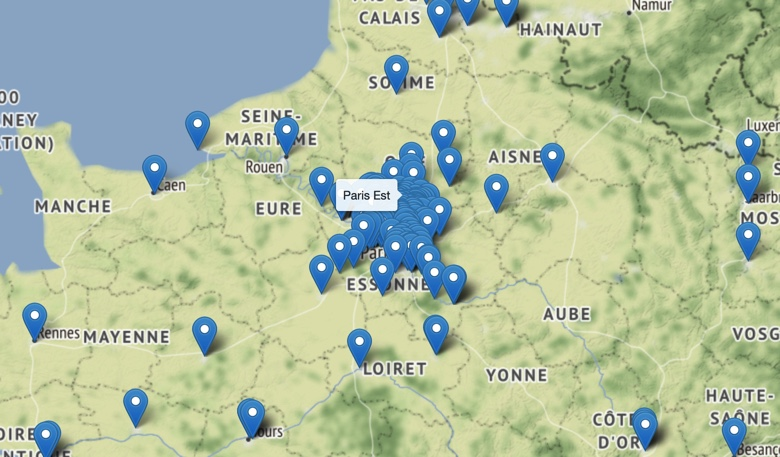